
In this notebook we implement the U-Net architerture on the full dataset. We use the following parameters: 
- Focal Loss
- Optimizer: Adam
- Batch Size = 64 
- Early Stopping after 10 epochs where the validation doesn't go down

The model saves the model as 'best_model_64b.pt'. We first run the model for 100 epochs: it stopped at epoch 42, with the best values achieved at epoch 32.




#### **Epoch 32/100**

| Metric       | Train         | Validation     |
|--------------|---------------|----------------|
| **Loss**     | 0.00041       | 0.00073        |
| **Accuracy** | 0.99750       | 0.99648        |
| **IoU**      | 0.81311       | 0.74226        |
| **Dice**     | 0.89678       | 0.85145        |

#### For predicting tumor segmentation masks, we will utilize U-Net architecture. 

## Install all the dependencies

In [ ]:
import os
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import json

# PyTorch related imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
from torch.nn import functional as F
from torch.nn.functional import binary_cross_entropy_with_logits

# For splitting dataset
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import default_collate


### Start by Visualizing the first 5 images

Printing first 5 images and masks in folder: image
Class Folder .DS_Store
Class Folder 0
image/0
Image 0
Image: image/0/Tr-noTr_0000.jpg, Mask: mask/0/Tr-noTr_0000_m.jpg


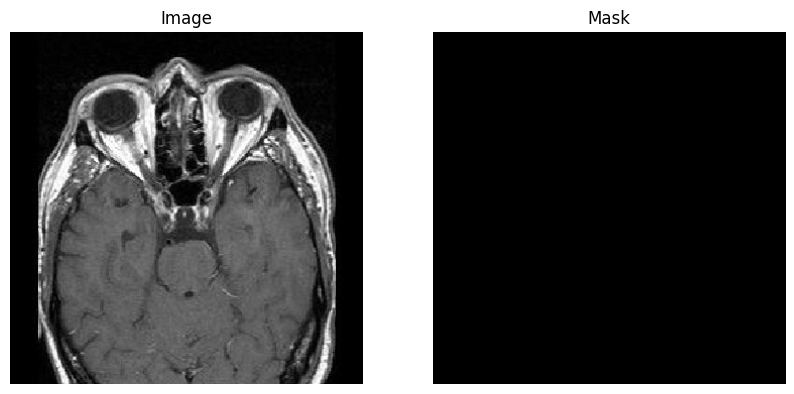

Image 1
Image: image/0/Tr-noTr_0001.jpg, Mask: mask/0/Tr-noTr_0001_m.jpg


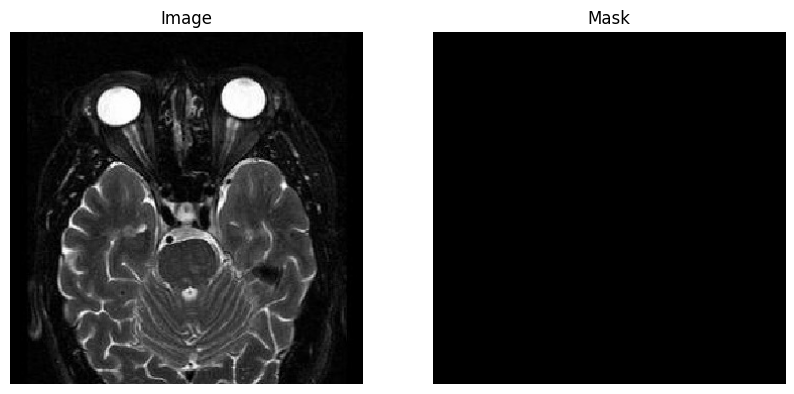

Image 2
Image: image/0/Tr-noTr_0002.jpg, Mask: mask/0/Tr-noTr_0002_m.jpg


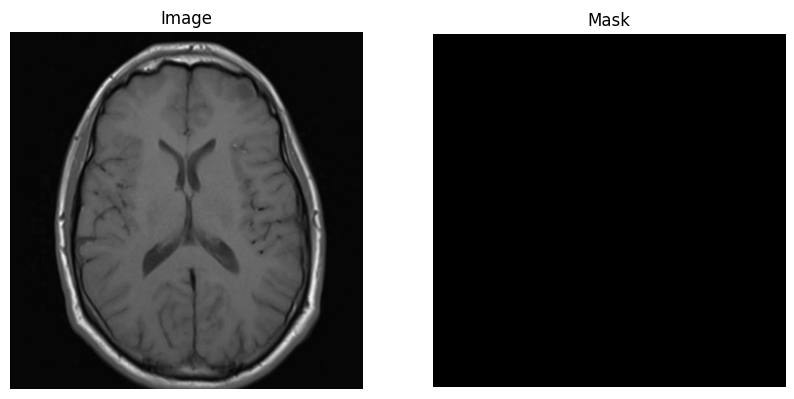

Image 3
Image: image/0/Tr-noTr_0003.jpg, Mask: mask/0/Tr-noTr_0003_m.jpg


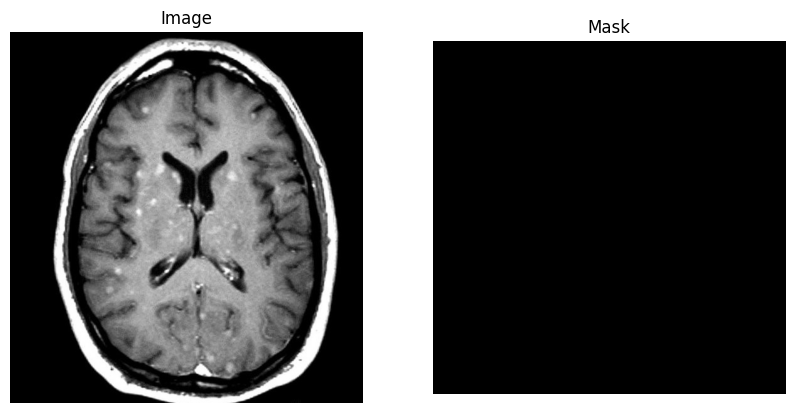

Image 4
Image: image/0/Tr-noTr_0004.jpg, Mask: mask/0/Tr-noTr_0004_m.jpg


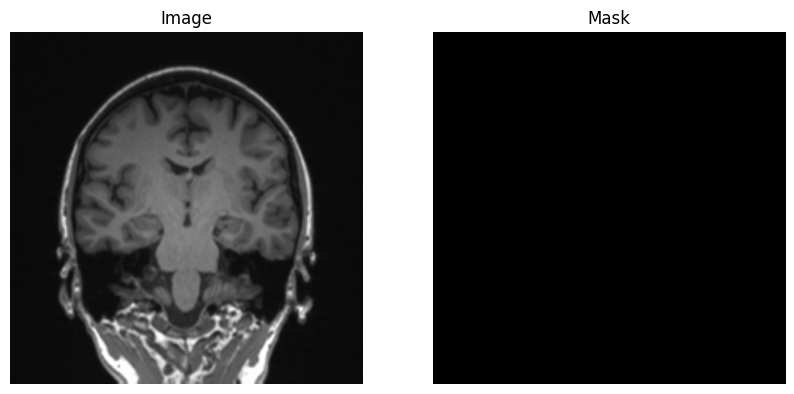

Class Folder 1
image/1
Image 0
Image: image/1/Tr-glTr_0000.jpg, Mask: mask/1/Tr-glTr_0000_m.jpg


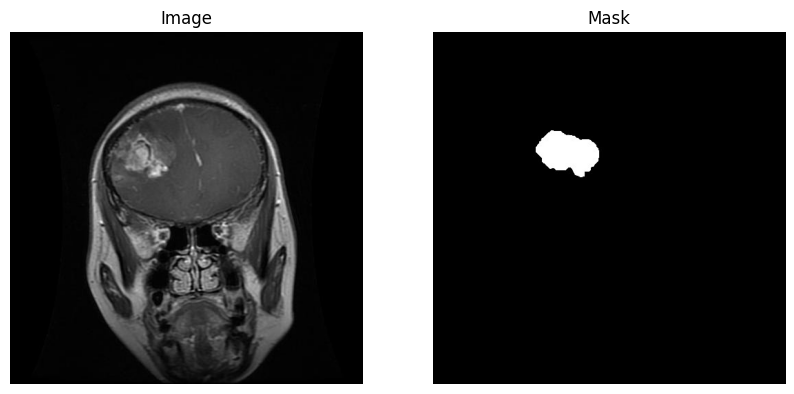

Image 1
Image: image/1/Tr-glTr_0001.jpg, Mask: mask/1/Tr-glTr_0001_m.jpg


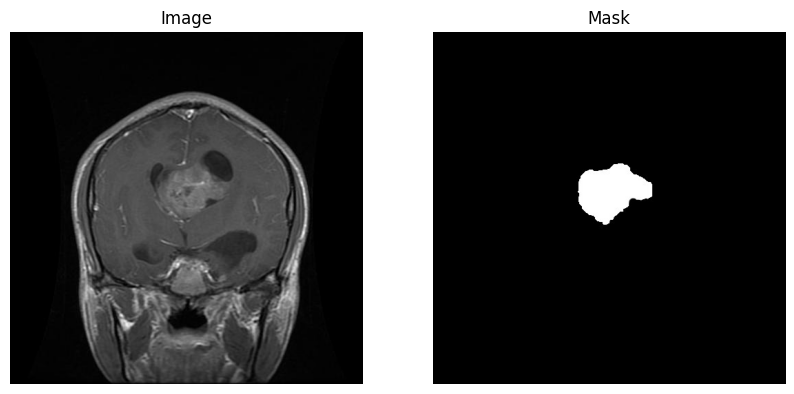

Image 2
Image: image/1/Tr-glTr_0003.jpg, Mask: mask/1/Tr-glTr_0003_m.jpg


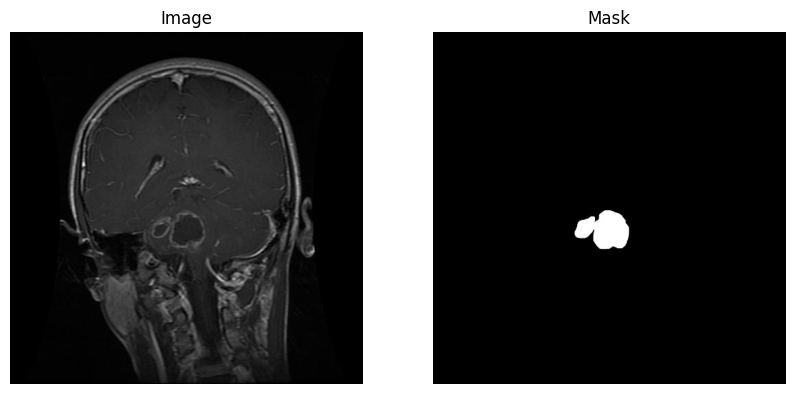

Image 3
Image: image/1/Tr-glTr_0007.jpg, Mask: mask/1/Tr-glTr_0007_m.jpg


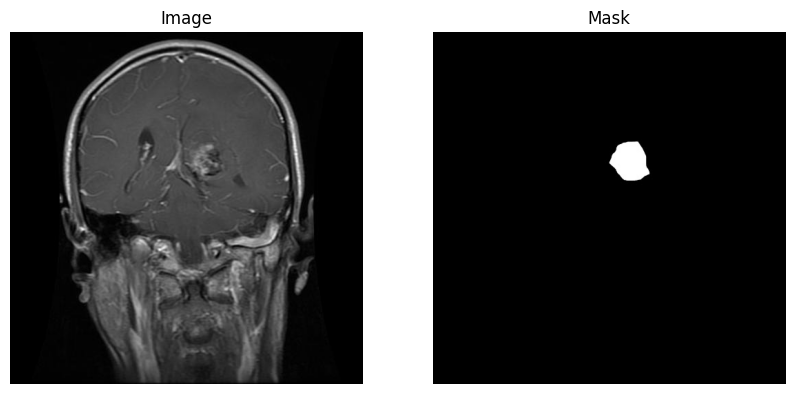

Image 4
Image: image/1/Tr-glTr_0009.jpg, Mask: mask/1/Tr-glTr_0009_m.jpg


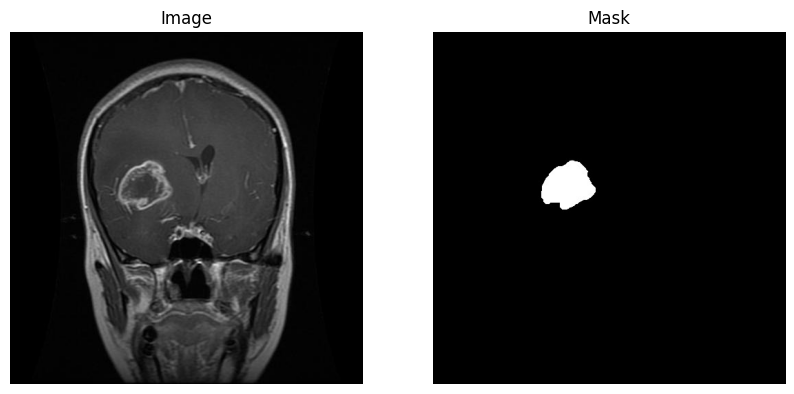

Class Folder 3
image/3
Image 0
Image: image/3/Tr-piTr_0000.jpg, Mask: mask/3/Tr-piTr_0000_m.jpg


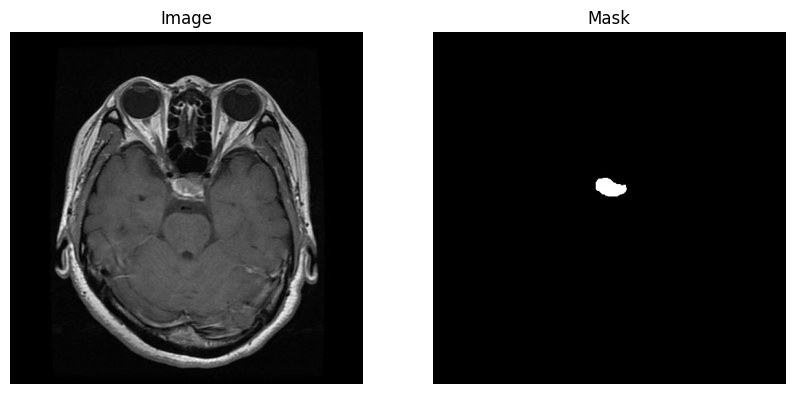

Image 1
Image: image/3/Tr-piTr_0001.jpg, Mask: mask/3/Tr-piTr_0001_m.jpg


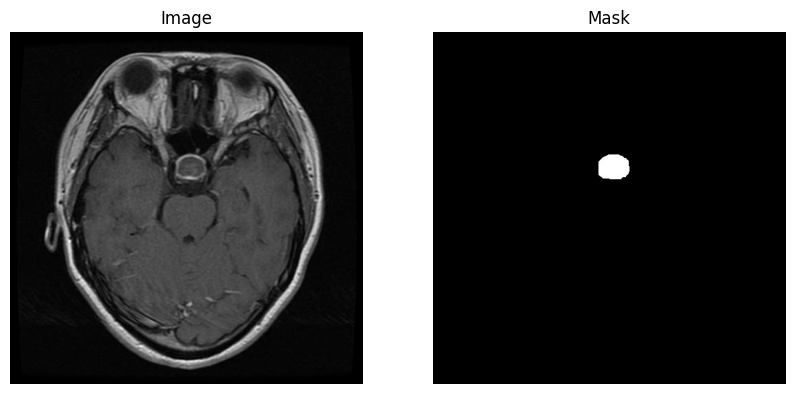

Image 2
Image: image/3/Tr-piTr_0002.jpg, Mask: mask/3/Tr-piTr_0002_m.jpg


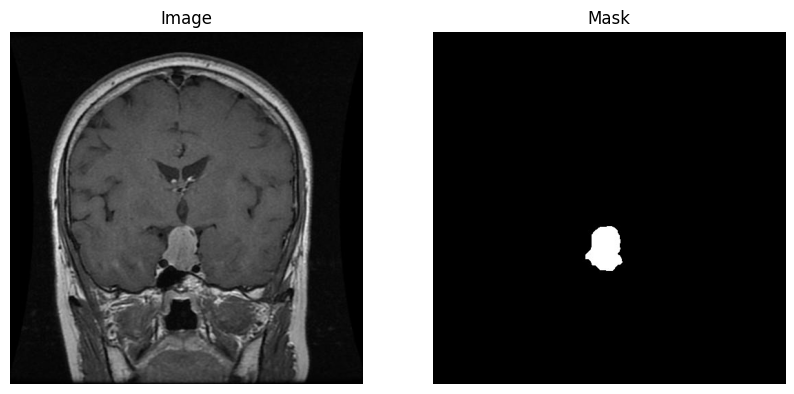

Image 3
Image: image/3/Tr-piTr_0003.jpg, Mask: mask/3/Tr-piTr_0003_m.jpg


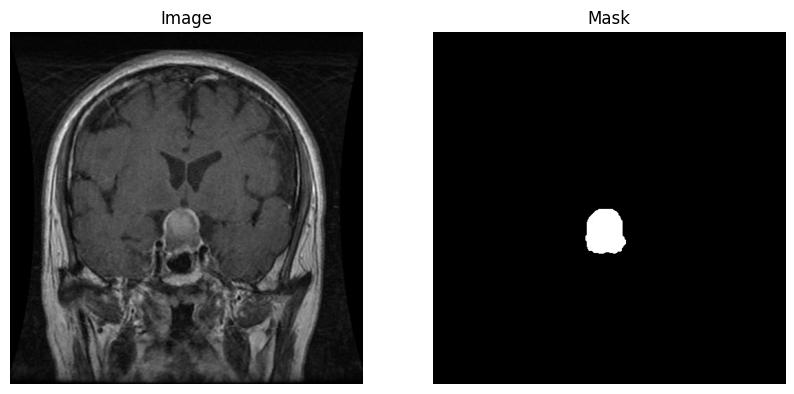

Image 4
Image: image/3/Tr-piTr_0006.jpg, Mask: mask/3/Tr-piTr_0006_m.jpg


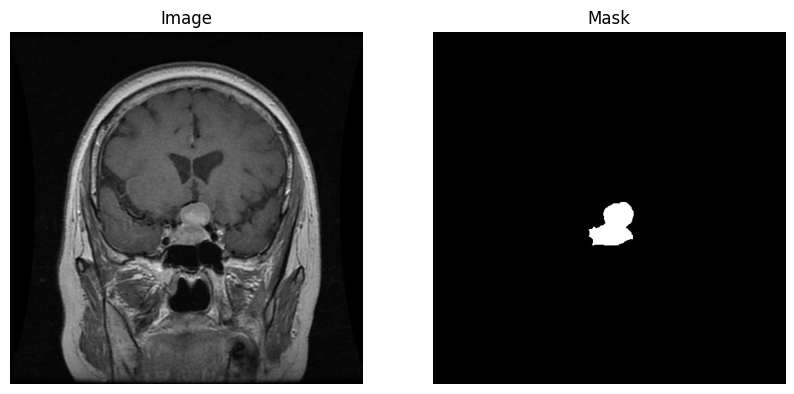

Class Folder 2
image/2
Image 0
Image: image/2/Tr-meTr_0001.jpg, Mask: mask/2/Tr-meTr_0001_m.jpg


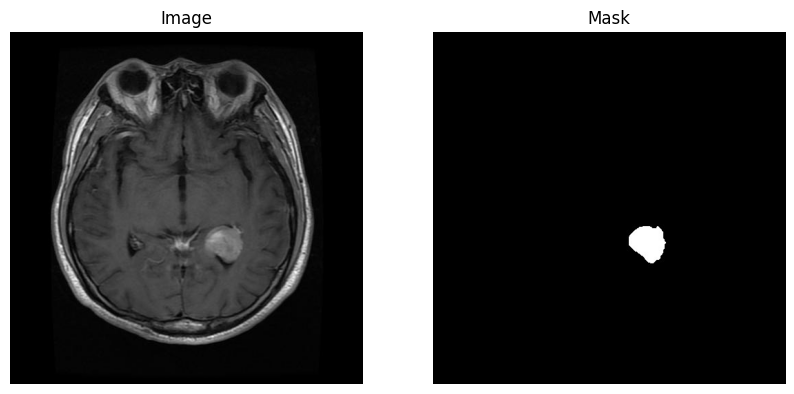

Image 1
Image: image/2/Tr-meTr_0005.jpg, Mask: mask/2/Tr-meTr_0005_m.jpg


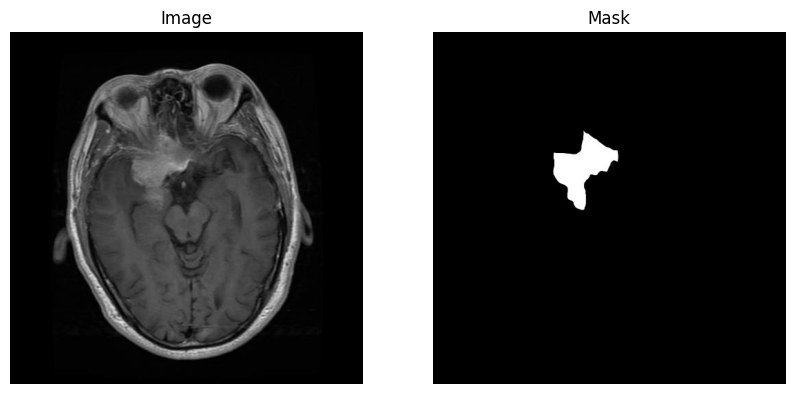

Image 2
Image: image/2/Tr-meTr_0007.jpg, Mask: mask/2/Tr-meTr_0007_m.jpg


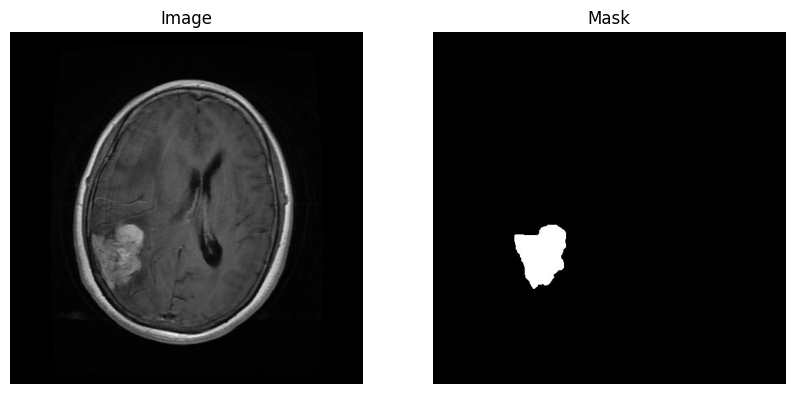

Image 3
Image: image/2/Tr-meTr_0008.jpg, Mask: mask/2/Tr-meTr_0008_m.jpg


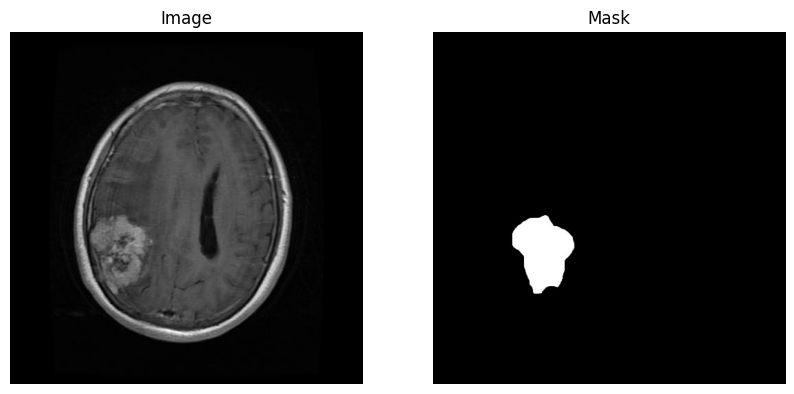

Image 4
Image: image/2/Tr-me_0010.jpg, Mask: mask/2/Tr-me_0010_m.jpg


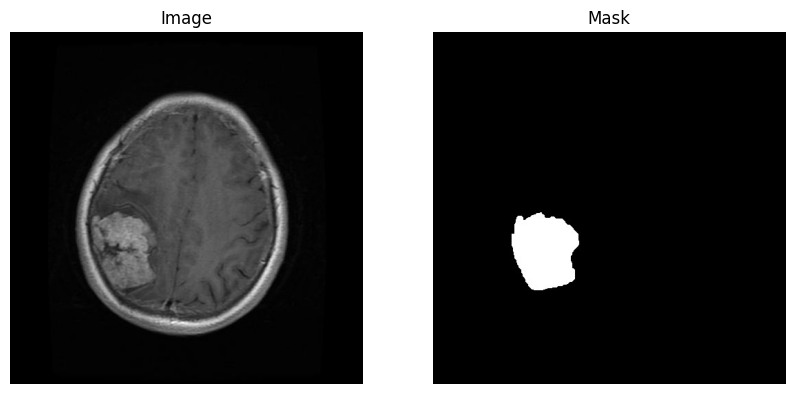

In [7]:
# Define the paths to the image and mask folders
image_folder = "image" # Define the path to image directory
mask_folder = "mask" # Define the path to image directory

# Define a function to print the first 5 images and their masks in a given folder
def print_first_5(folder):
    print(f"Printing first 5 images and masks in folder: {folder}")
    for class_folder in os.listdir(folder):  # Traverse through the subdirectories
        print(f"Class Folder {class_folder}")
        class_path = os.path.join(folder, class_folder)
        if not os.path.isdir(class_path):
            continue
        print(class_path)
        image_files = sorted(os.listdir(class_path))
        for i in range(5):
            print(f"Image {i}")
            image_path = os.path.join(class_path, image_files[i])
            mask_path = os.path.join(mask_folder, class_folder, image_files[i].replace(".jpg", "_m.jpg"))
            print(f"Image: {image_path}, Mask: {mask_path}")
            # Open and display the image and mask side by side
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            image = Image.open(image_path)
            mask = Image.open(mask_path)
            axes[0].imshow(image)
            axes[0].set_title('Image')
            axes[0].axis('off')
            axes[1].imshow(mask)
            axes[1].set_title('Mask')
            axes[1].axis('off')
            plt.show()

# Call the function for both image and mask folders
print_first_5(image_folder)
#print_first_5(mask_folder)


#### Train-validation Split

In [8]:
# Define paths to image and mask folders
image_folder = "image"   # customize with your own path to images
mask_folder = "mask"     # customize with your own path to masks

# Function to load and preprocess images and masks
def load_data(image_folder, mask_folder, desired_shape):
    images = []
    masks = []
    image_paths = []
    mask_paths = []
    for class_folder in os.listdir(image_folder):
        if class_folder.startswith('.'):
            continue
        class_path_image = os.path.join(image_folder, class_folder)
        class_path_mask = os.path.join(mask_folder, class_folder)
        for file_name in os.listdir(class_path_image):
            if file_name.startswith('.'):
                continue
            # Define image and mask paths
            image_path = os.path.join(class_path_image, file_name)
            mask_path = os.path.join(class_path_mask, file_name.replace(".jpg", "_m.jpg"))
            
            # Load and process image
            image = Image.open(image_path).convert('L')
            image = image.resize(desired_shape)
            image = np.array(image) / 255.0

            # Load and process mask
            mask = Image.open(mask_path).convert('L')
            mask = mask.resize(desired_shape)
            mask = np.array(mask)
            mask = np.where(mask > 0, 1, 0)
            
            images.append(image)
            masks.append(mask)
            image_paths.append(image_path)
            mask_paths.append(mask_path)
    
    images = np.array(images)
    masks = np.array(masks)
    return images, masks, image_paths, mask_paths

# Load and preprocess data
desired_shape = (256, 256)
images, masks, image_paths, mask_paths = load_data(image_folder, mask_folder, desired_shape)

# Split data into train and validation sets
train_images, val_images, train_masks, val_masks, train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    images, masks, image_paths, mask_paths, test_size=0.2, random_state=42
)

# Convert numpy arrays to PyTorch tensors
train_images = torch.from_numpy(train_images).float().unsqueeze(1)
train_masks = torch.from_numpy(train_masks).float().unsqueeze(1)
val_images = torch.from_numpy(val_images).float().unsqueeze(1)
val_masks = torch.from_numpy(val_masks).float().unsqueeze(1)

# Create DataFrames for CSV output
train_df = pd.DataFrame({'Image_Path': train_image_paths, 'Mask_Path': train_mask_paths})
val_df = pd.DataFrame({'Image_Path': val_image_paths, 'Mask_Path': val_mask_paths})

# Save to CSV
train_df.to_csv('train_paths.csv', index=False)
val_df.to_csv('val_paths.csv', index=False)

print("Train Images Shape:", train_images.shape)
print("Train Masks Shape:", train_masks.shape)
print("Validation Images Shape:", val_images.shape)
print("Validation Masks Shape:", val_masks.shape)


Train Images Shape: torch.Size([3389, 1, 256, 256])
Train Masks Shape: torch.Size([3389, 1, 256, 256])
Validation Images Shape: torch.Size([848, 1, 256, 256])
Validation Masks Shape: torch.Size([848, 1, 256, 256])


### The U-Net Model

In [10]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Encoder
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.decoder1 = self.conv_block(1024 + 512, 512)
        self.decoder2 = self.conv_block(512 + 256, 256)
        self.decoder3 = self.conv_block(256 + 128, 128)
        self.decoder4 = self.conv_block(128 + 64, 64)
        
        # Final convolution
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )
        return block
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(nn.MaxPool2d(2)(enc1))
        enc3 = self.encoder3(nn.MaxPool2d(2)(enc2))
        enc4 = self.encoder4(nn.MaxPool2d(2)(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))
        
        # Decoder
        dec1 = self.decoder1(torch.cat([nn.functional.interpolate(bottleneck, scale_factor=2, mode='nearest'), enc4], 1))
        dec2 = self.decoder2(torch.cat([nn.functional.interpolate(dec1, scale_factor=2, mode='nearest'), enc3], 1))
        dec3 = self.decoder3(torch.cat([nn.functional.interpolate(dec2, scale_factor=2, mode='nearest'), enc2], 1))
        dec4 = self.decoder4(torch.cat([nn.functional.interpolate(dec3, scale_factor=2, mode='nearest'), enc1], 1))
        
        # Output
        return self.final_conv(dec4)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE = binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        BCE_exp = torch.exp(-BCE)
        focal_loss = self.alpha * (1-BCE_exp)**self.gamma * BCE
        return focal_loss.mean()

In [11]:
# Metrics of Accuracy
def intersection_over_union(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

def dice_coefficient(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = torch.sum(pred * target)
    return (2. * intersection + 1e-7) / (torch.sum(pred) + torch.sum(target) + 1e-7)

def pixel_accuracy(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)
    correct = torch.sum(pred == target).float()
    return correct / target.numel()

In [12]:
# Early Stopping Class
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [13]:
#Step 1: Define the Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, images, masks, paths):
        self.images = images
        self.masks = masks
        self.paths = paths

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        path = self.paths[idx]
        return image, mask, path


In [14]:
def custom_collate(batch):
    data = [item[0:2] for item in batch]
    paths = [item[2] for item in batch]
    data_collated = default_collate(data)
    return [*data_collated, paths]

In [15]:
# Step 2: Load the Data and Initialize DataLoaders

# Assuming 'train_images', 'train_masks', 'val_images', 'val_masks' are defined
train_paths_df = pd.read_csv('train_paths.csv')
val_paths_df = pd.read_csv('val_paths.csv')

train_dataset = CustomDataset(train_images, train_masks, train_paths_df[['Image_Path', 'Mask_Path']].values)
val_dataset = CustomDataset(val_images, val_masks, val_paths_df[['Image_Path', 'Mask_Path']].values)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=custom_collate)


# Define lists to hold loss and accuracy metrics over epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []


In [11]:
# Step 3:  Training Loop with Metric Calculation and Path Logging
# Define your model, loss, optimizer, and early stopping mechanism
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1).to(device)
criterion = FocalLoss()  # Assuming FocalLoss is defined somewhere
optimizer = optim.Adam(model.parameters(), lr=0.001)

early_stopping = EarlyStopping(patience=10, verbose=True, path='best_model_64b.pt')

epoch_logs = {}
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss, train_acc, train_iou, train_dice = 0, 0, 0, 0
    train_path_logs = []
    val_path_logs = []
    for images, masks, paths in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        outputs = torch.sigmoid(outputs) > 0.5  # Convert outputs to binary format for metric calculation
        train_loss += loss.item()
        train_acc += pixel_accuracy(outputs, masks)
        train_iou += intersection_over_union(outputs, masks)
        train_dice += dice_coefficient(outputs, masks)
        train_path_logs.extend(paths)

    
    # Normalize and log metrics after each epoch
    num_batches = len(train_loader)
    train_loss /= num_batches
    train_acc /= num_batches
    train_iou /= num_batches
    train_dice /= num_batches

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_ious.append(train_iou)
    train_dices.append(train_dice)
    epoch_logs[f'train_epoch_{epoch+1}'] = train_path_logs
    
    # Print epoch summary
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.5f}, Accuracy: {train_acc:.5f}, IoU: {train_iou:.5f}, Dice: {train_dice:.5f}')

    model.eval()
    val_loss, val_acc, val_iou, val_dice = 0, 0, 0, 0
    with torch.no_grad():
        for images, masks, paths in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            val_loss += criterion(outputs, masks).item()
            pred_masks = torch.sigmoid(outputs) > 0.5
            val_acc += pixel_accuracy(pred_masks, masks)
            val_iou += intersection_over_union(pred_masks, masks)
            val_dice += dice_coefficient(pred_masks, masks)
            val_path_logs.extend(paths)
    
    # Normalize validation metrics
    num_batches = len(val_loader)
    val_loss /= num_batches
    val_acc /= num_batches
    val_iou /= num_batches
    val_dice /= num_batches

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_ious.append(val_iou)
    val_dices.append(val_dice)
    epoch_logs[f'val_epoch_{epoch+1}'] = val_path_logs
    
    # Print validation summary
    print(f'............. Val Loss: {val_loss:.5f}, Accuracy: {val_acc:.5f}, IoU: {val_iou:.5f}, Dice: {val_dice:.5f}')

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break


Epoch 1/100, Train Loss: 0.03221, Accuracy: 0.92325, IoU: 0.14992, Dice: 0.24944
............. Val Loss: 0.02976, Accuracy: 0.92950, IoU: 0.06326, Dice: 0.11848
Validation loss decreased (inf --> 0.029761). Saving model ...
Epoch 2/100, Train Loss: 0.01690, Accuracy: 0.98837, IoU: 0.21539, Dice: 0.34450
............. Val Loss: 0.00982, Accuracy: 0.98774, IoU: 0.00022, Dice: 0.00044
Validation loss decreased (0.029761 --> 0.009821). Saving model ...
Epoch 3/100, Train Loss: 0.00728, Accuracy: 0.98939, IoU: 0.22502, Dice: 0.35573
............. Val Loss: 0.00534, Accuracy: 0.98936, IoU: 0.12612, Dice: 0.22182
Validation loss decreased (0.009821 --> 0.005338). Saving model ...
Epoch 4/100, Train Loss: 0.00390, Accuracy: 0.99060, IoU: 0.32151, Dice: 0.48250
............. Val Loss: 0.00374, Accuracy: 0.98725, IoU: 0.26408, Dice: 0.41469
Validation loss decreased (0.005338 --> 0.003736). Saving model ...
Epoch 5/100, Train Loss: 0.00285, Accuracy: 0.99118, IoU: 0.37936, Dice: 0.54691
........

### Plot the scores

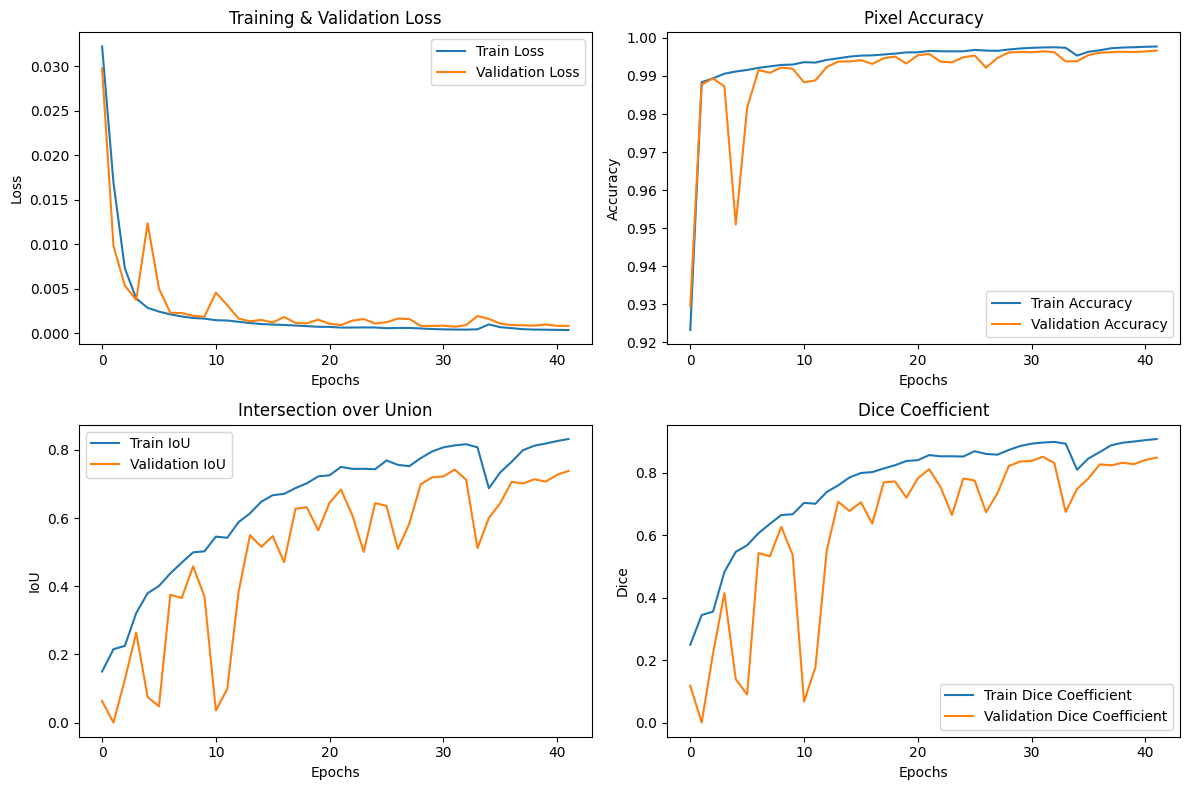

In [12]:
# Plotting the results
plt.figure(figsize=(12, 8))

# Loss Plot
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Pixel Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# IoU Plot
plt.subplot(2, 2, 3)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Validation IoU')
plt.title('Intersection over Union')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

# Dice Coefficient Plot
plt.subplot(2, 2, 4)
plt.plot(train_dices, label='Train Dice Coefficient')
plt.plot(val_dices, label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()

plt.tight_layout()
plt.show()


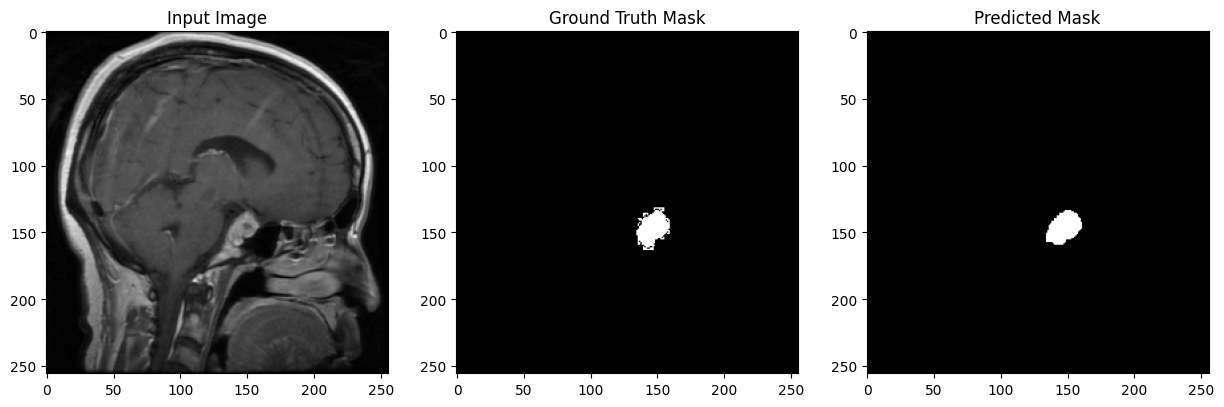

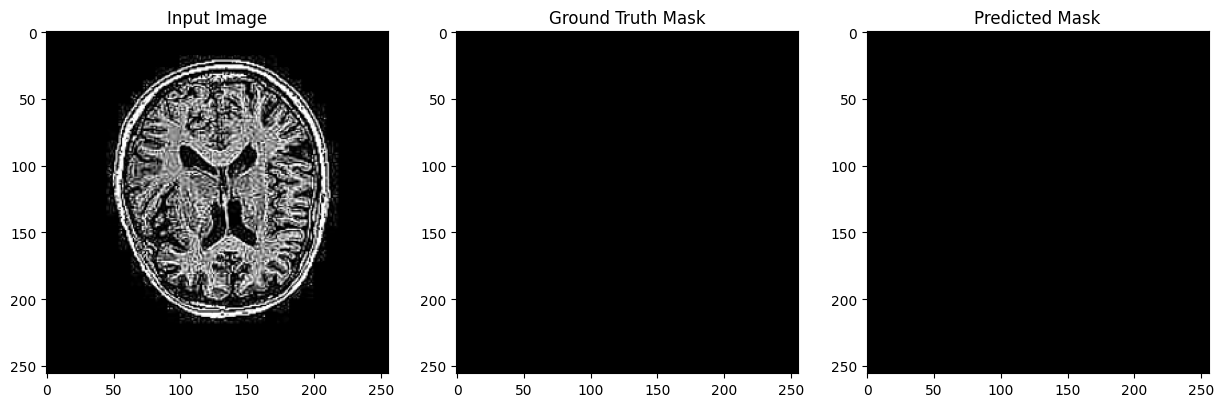

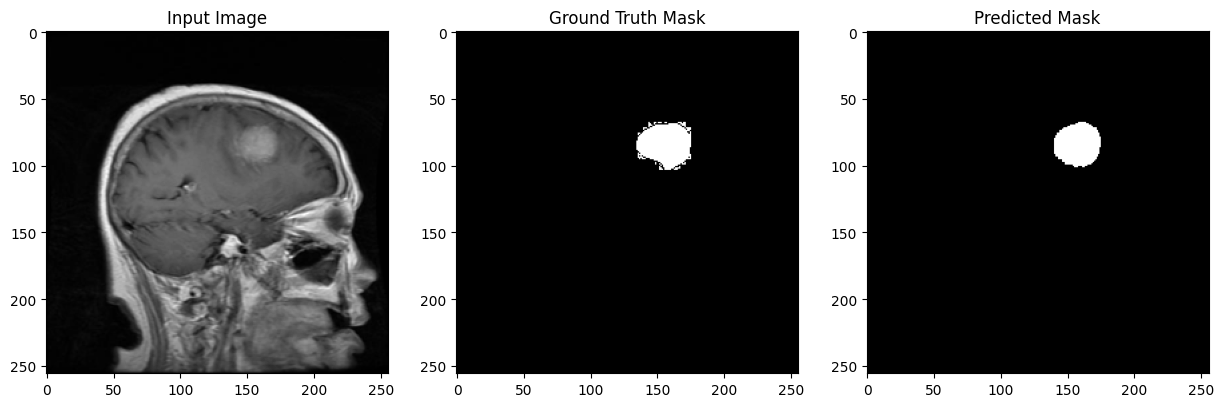

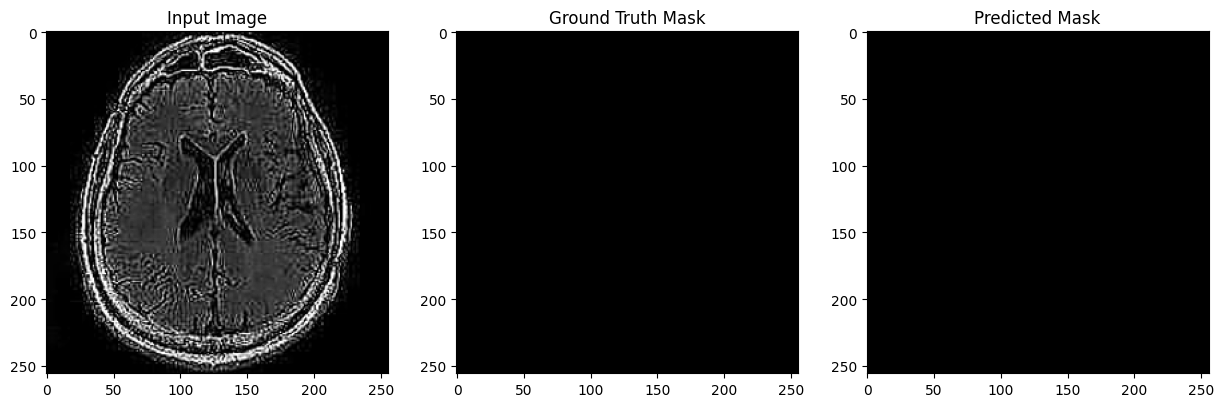

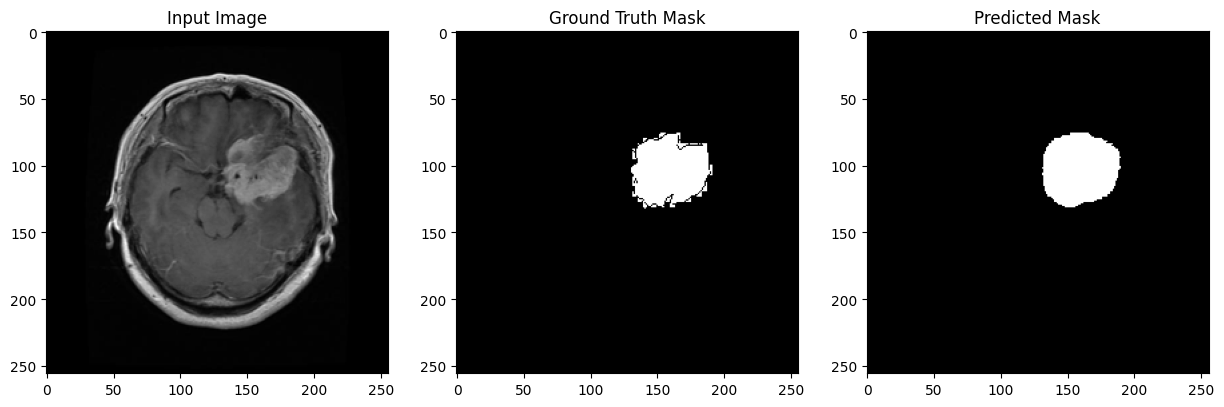

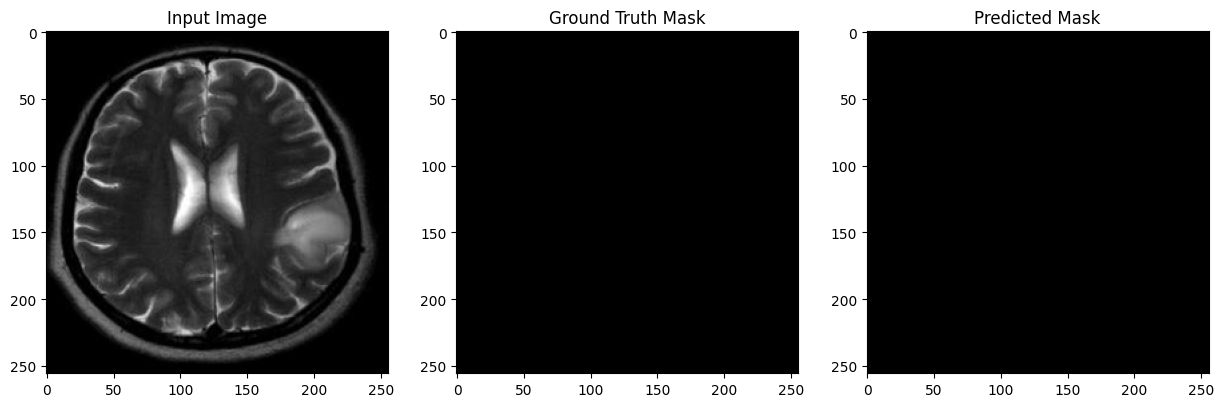

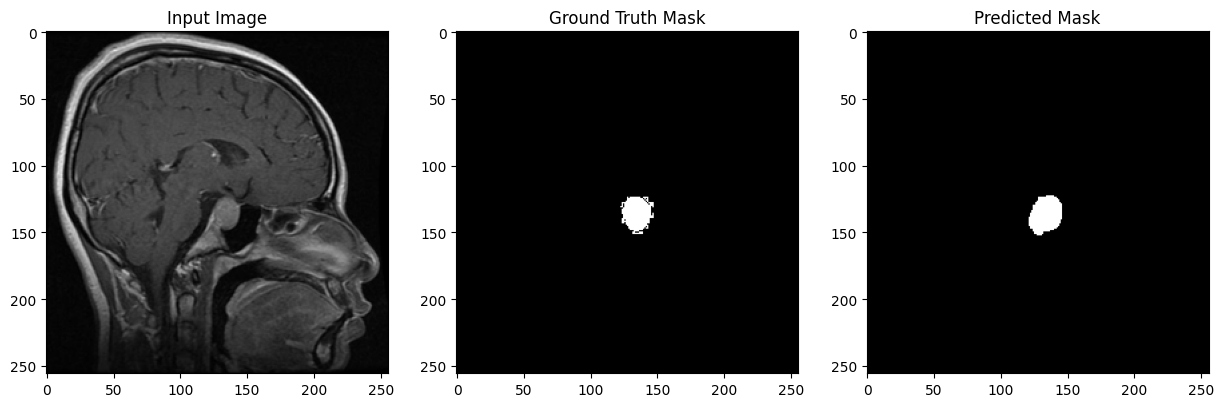

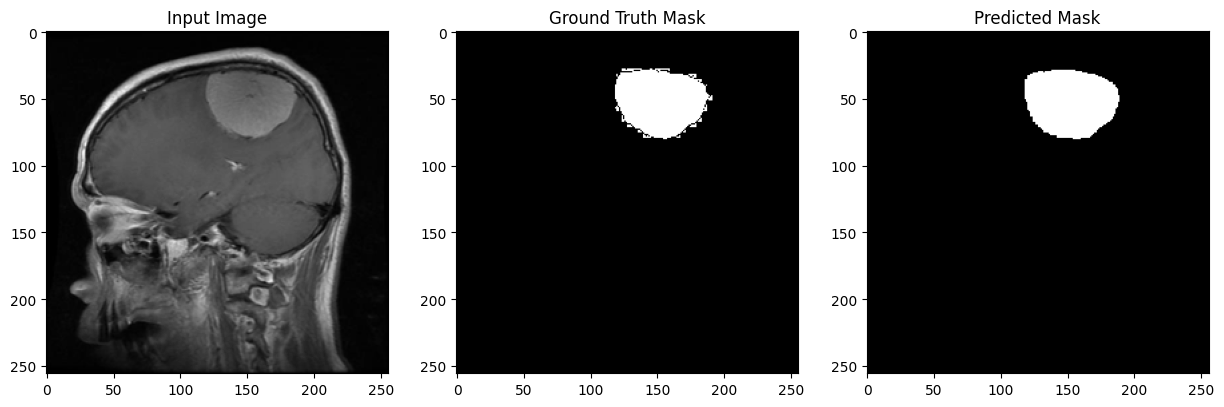

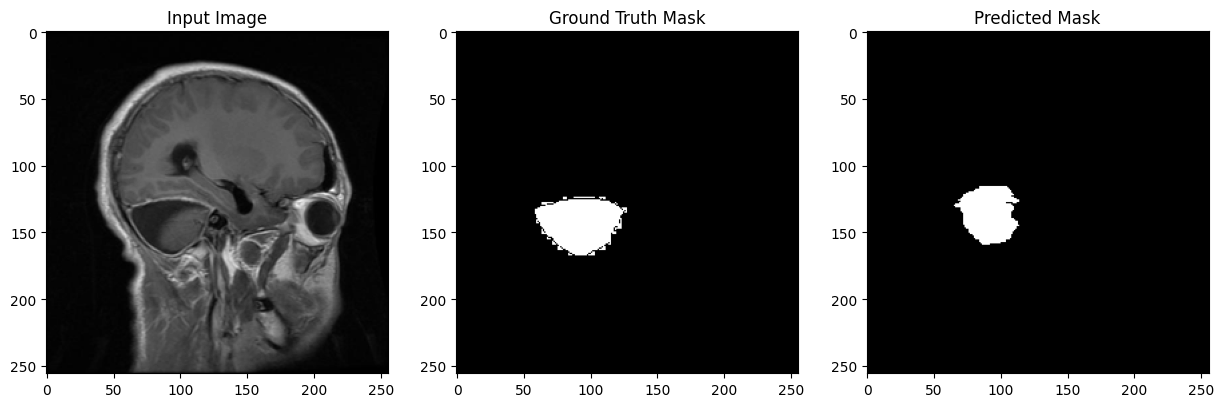

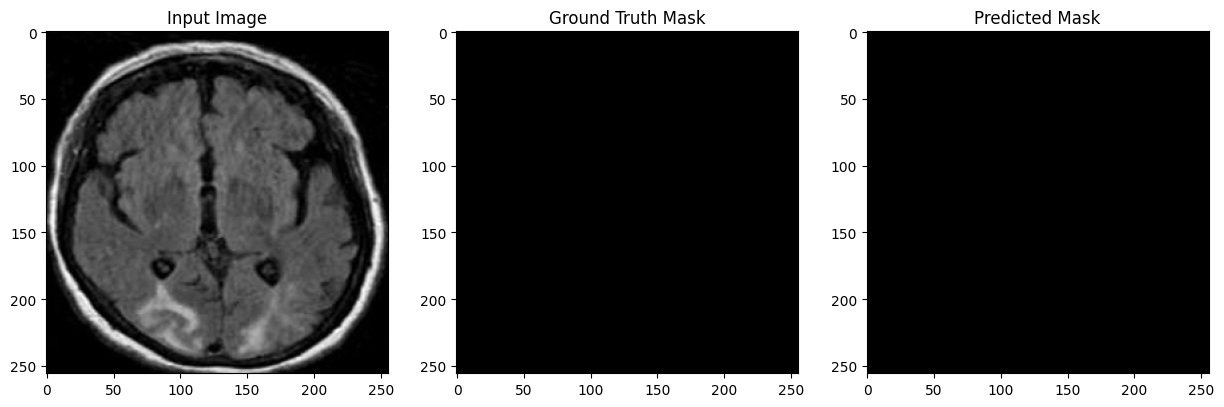

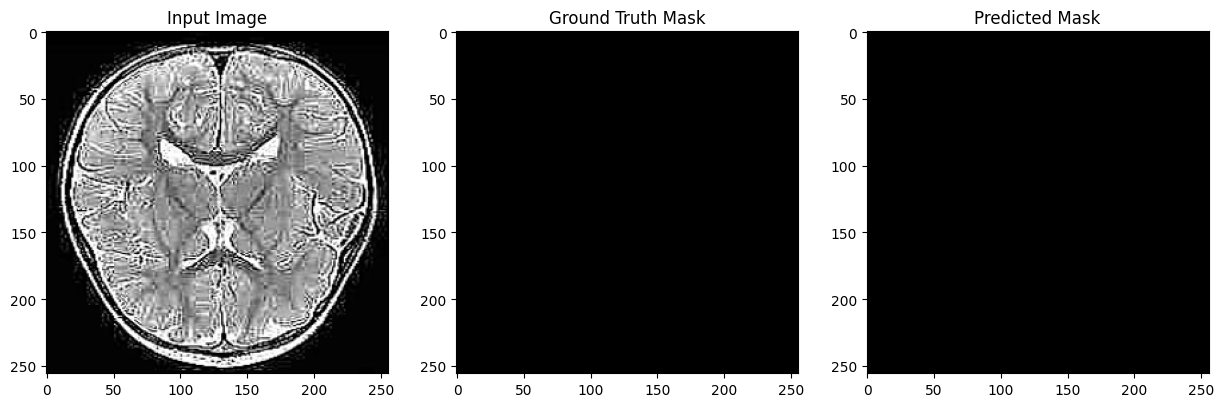

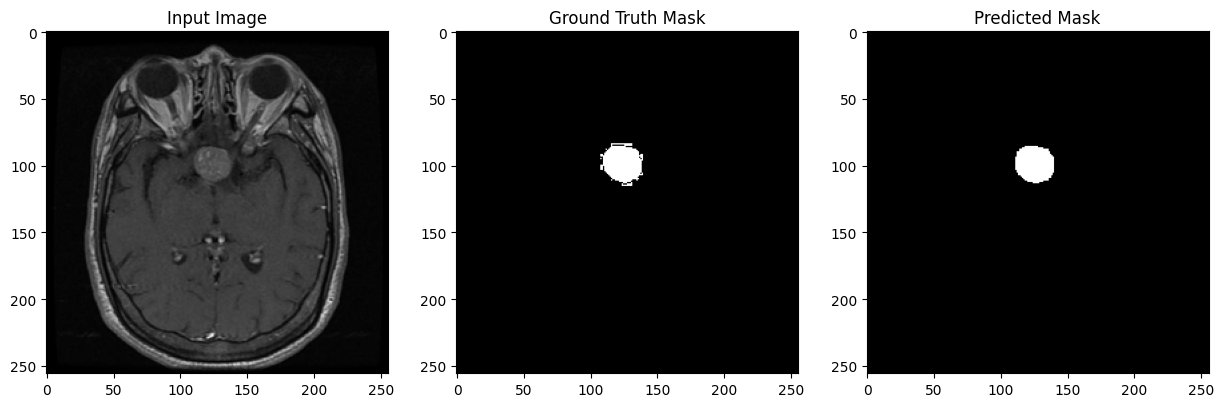

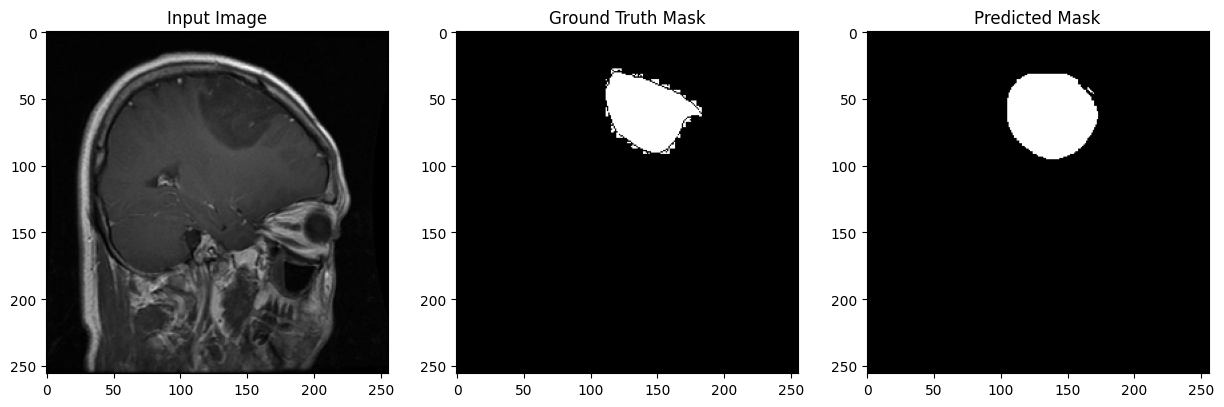

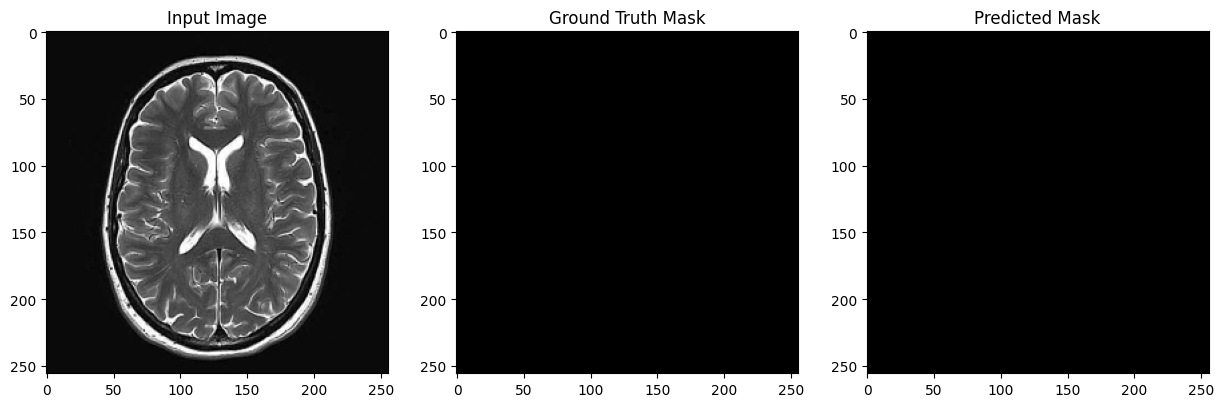

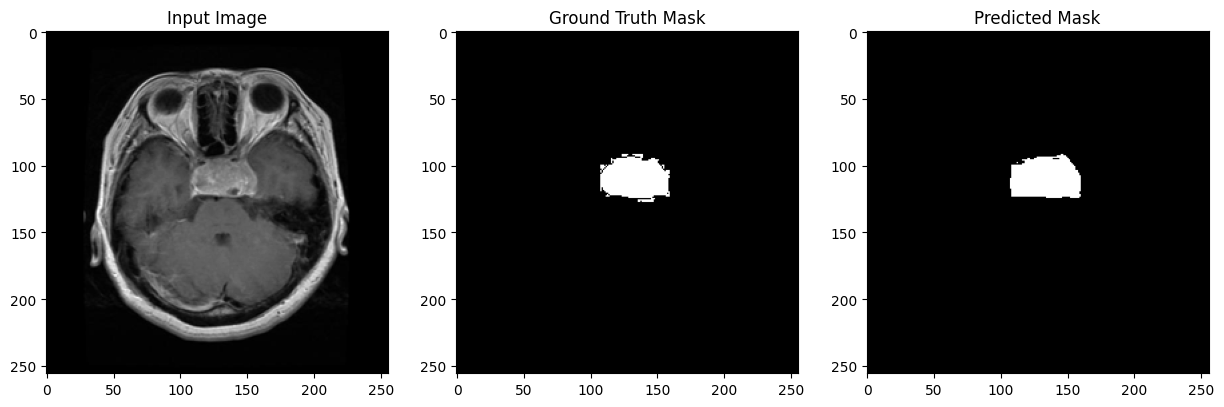

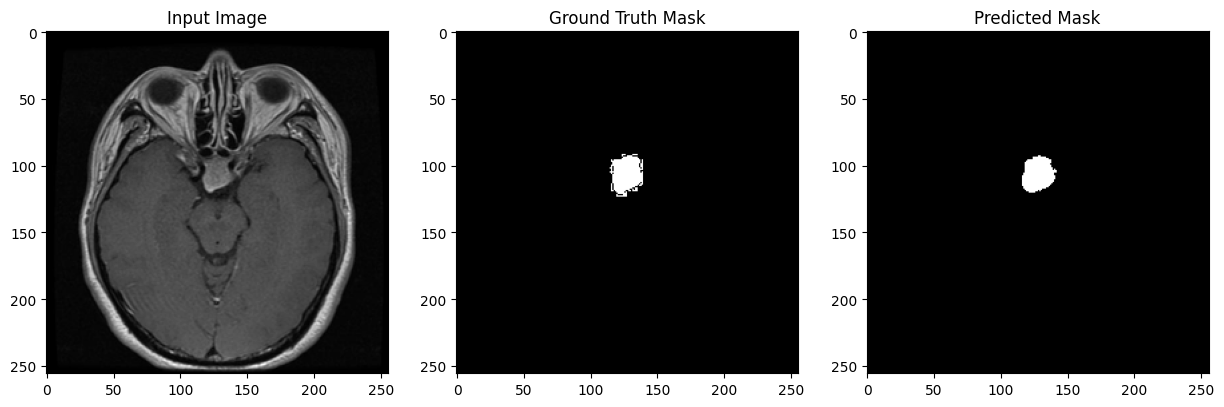

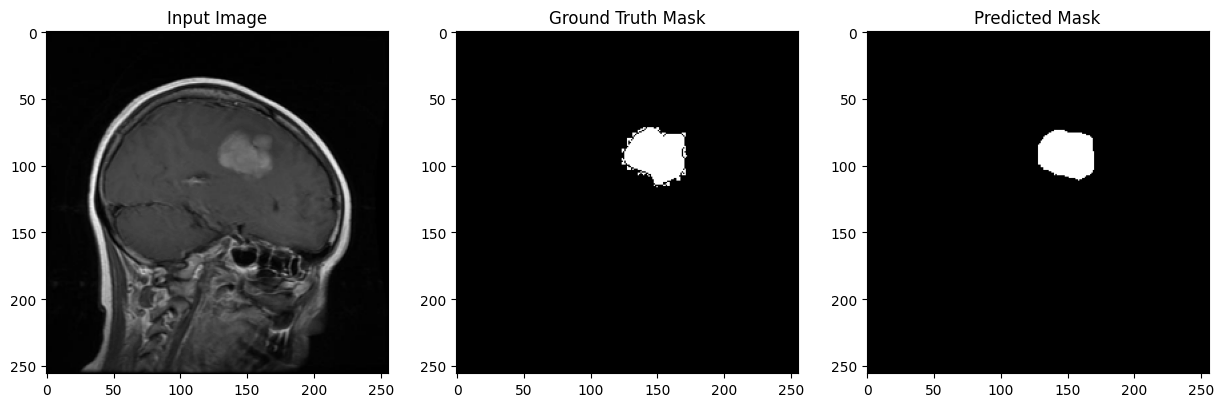

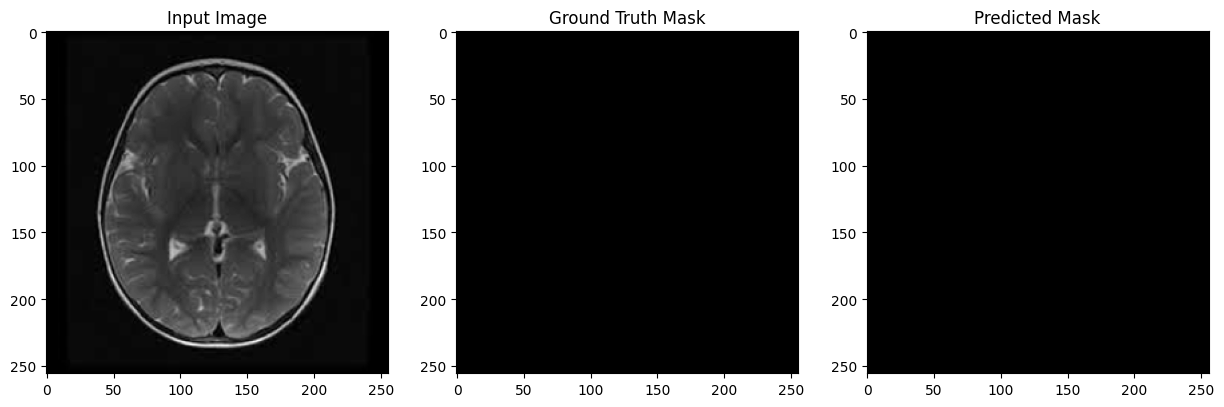

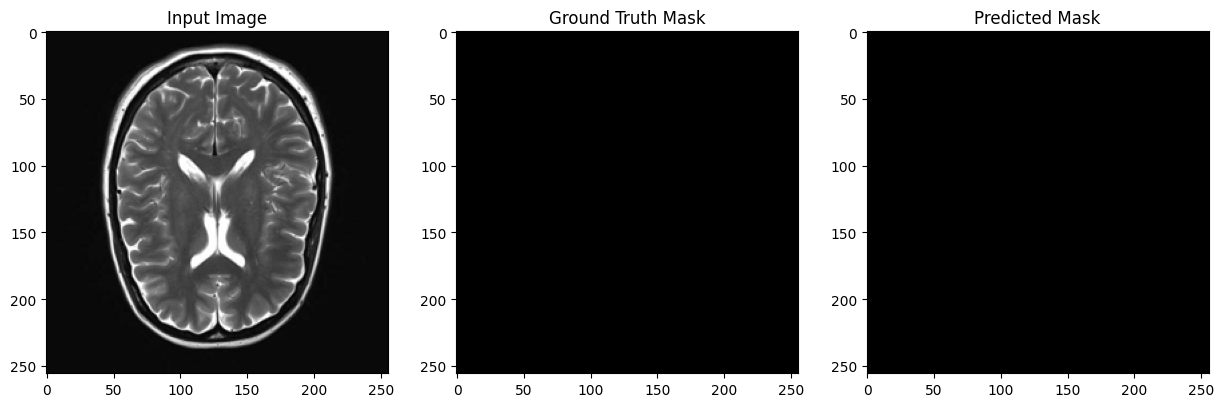

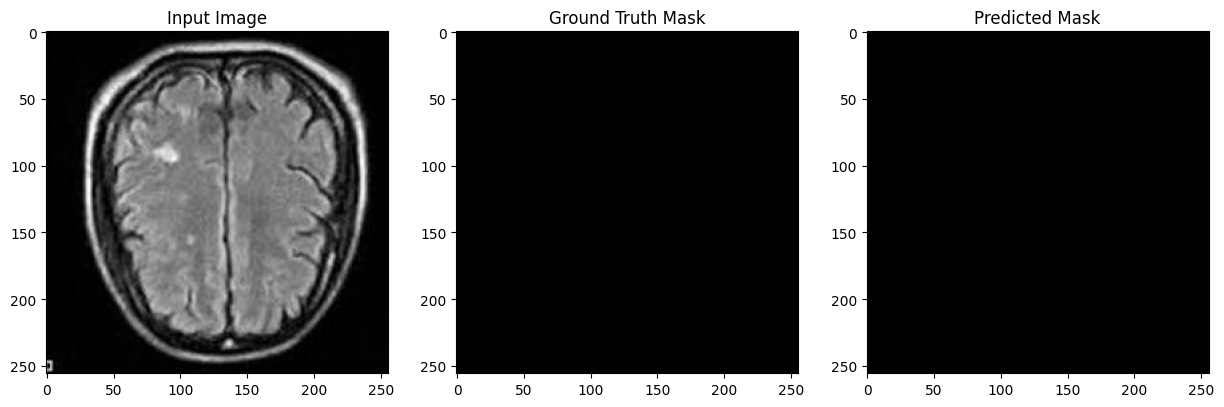

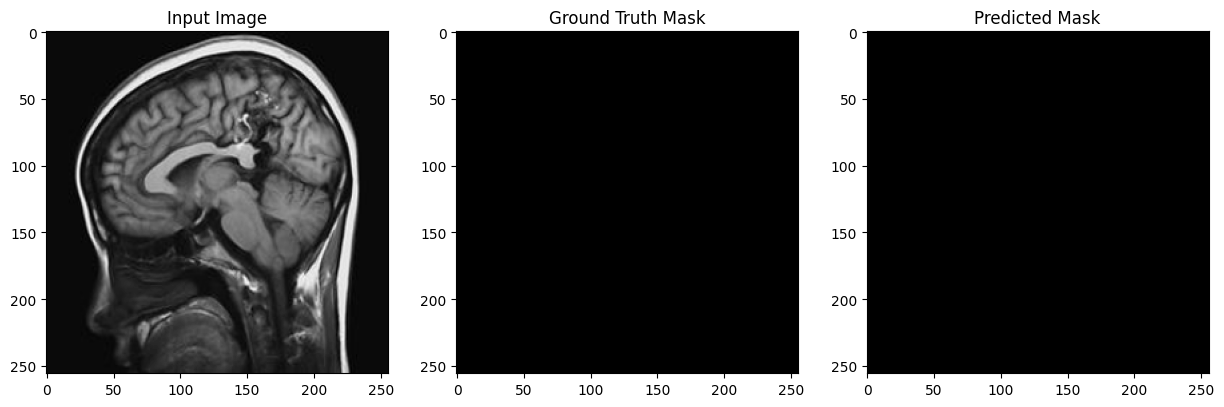

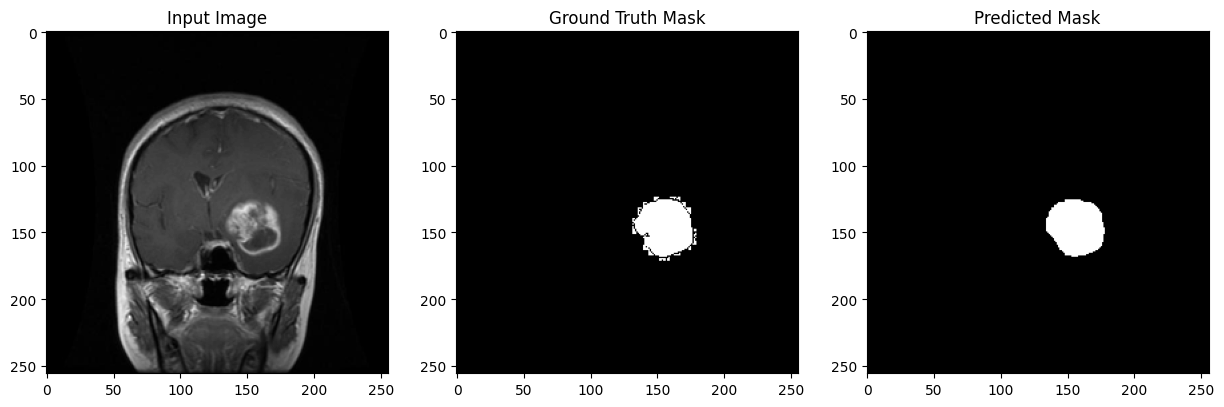

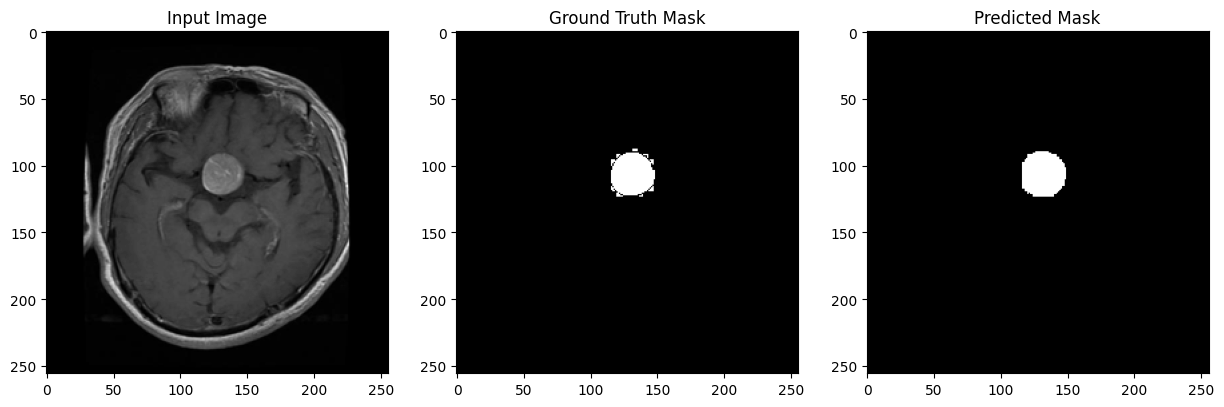

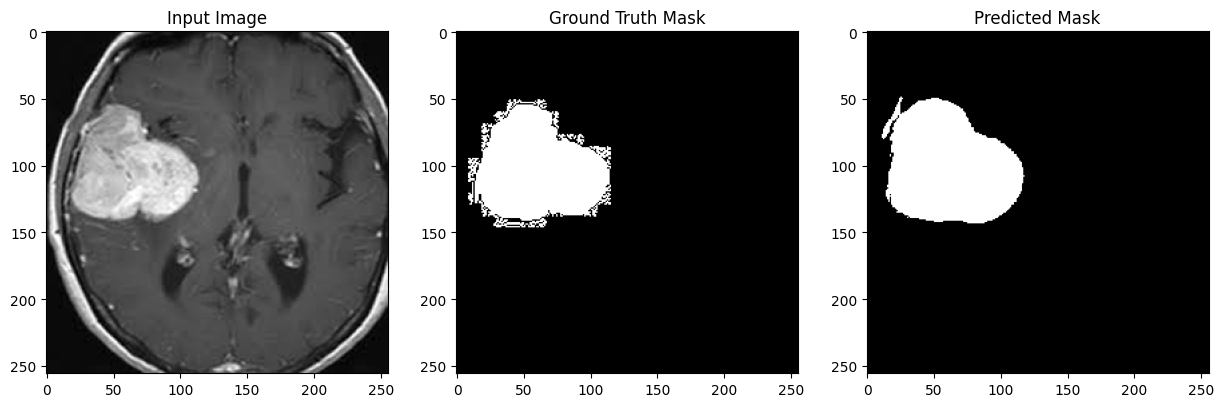

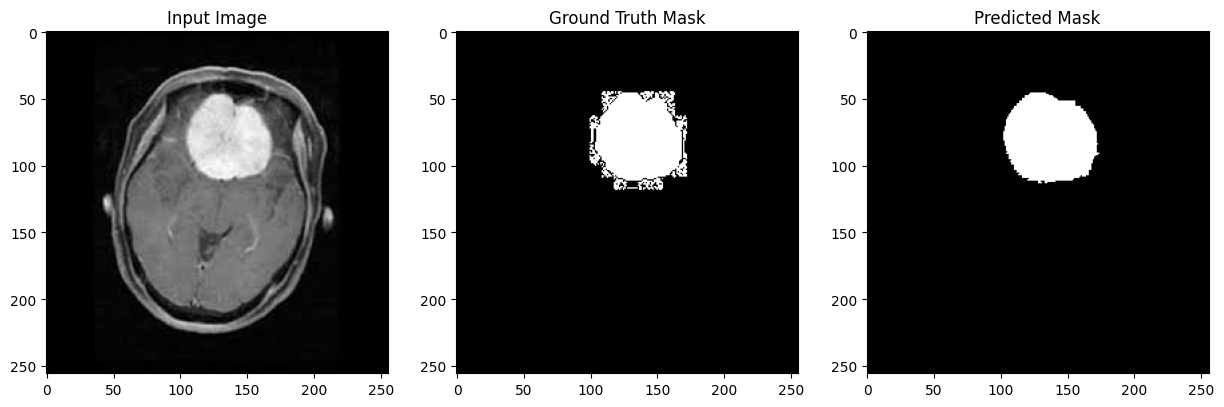

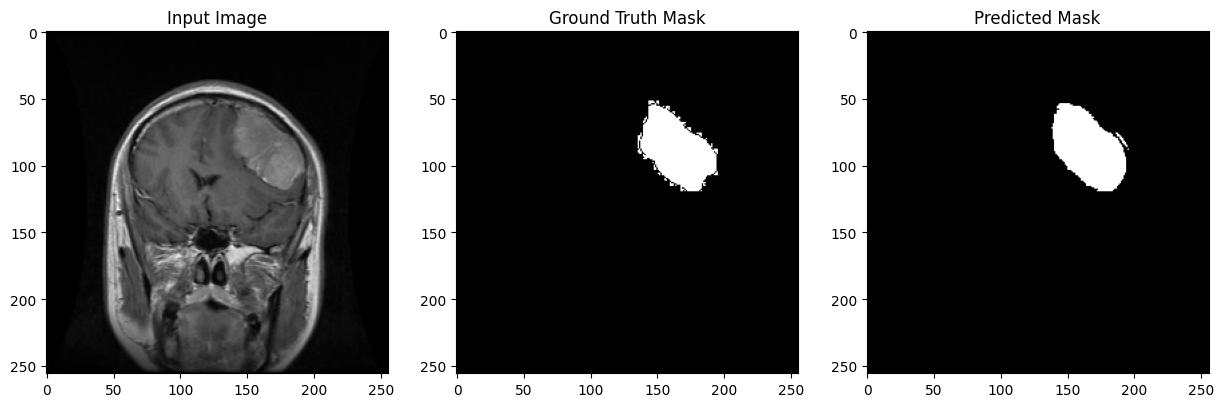

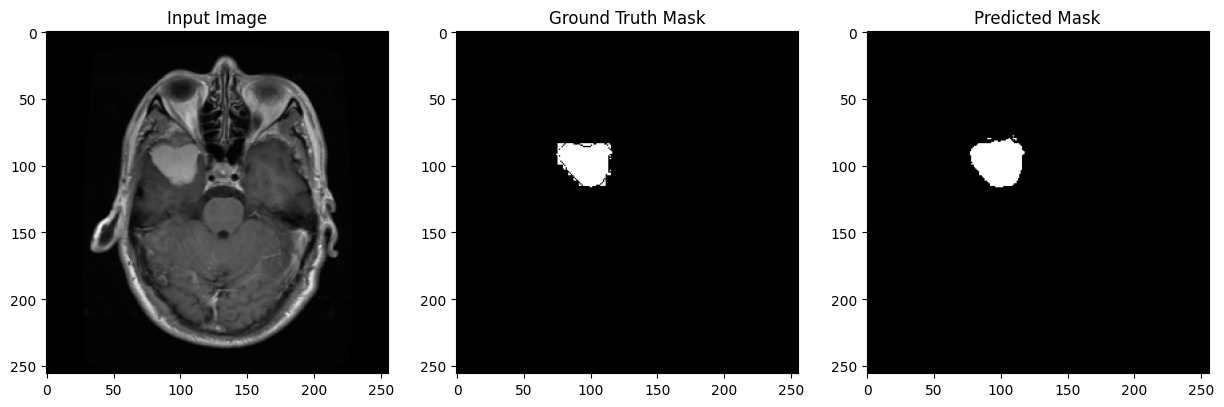

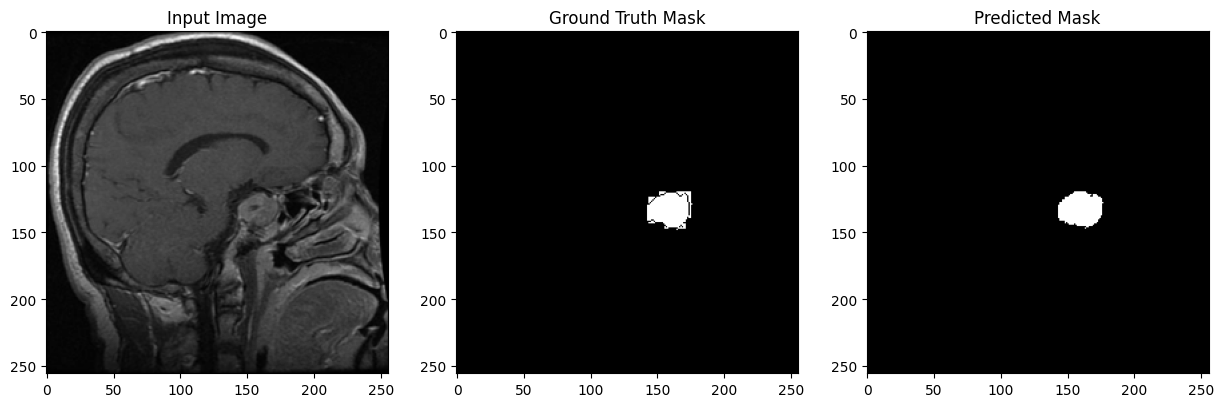

In [18]:
import torch
import torch.nn as nn

# Use the UNet class defined above
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1).to(device)  # Make sure you have first load the model and device

# Load the state dict into the model
state_dict = torch.load('best_model_64b.pt')   #'best_model_64b.pt' was saved before
model.load_state_dict(state_dict)

model.eval()
with torch.no_grad():
    for images, masks, paths in val_loader:  # Include paths in the unpacking
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
        
        # Plotting examples for each image in the batch
        for i in range(2):  # Starting index from 0 to show all images
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(images[i][0].cpu(), cmap='gray')
            plt.title('Input Image')
            
            plt.subplot(1, 3, 2)
            plt.imshow(masks[i][0].cpu(), cmap='gray')
            plt.title('Ground Truth Mask')
            
            plt.subplot(1, 3, 3)
            plt.imshow(predicted_masks[i][0].cpu(), cmap='gray')
            plt.title('Predicted Mask')
            
            plt.show()